# Predict Representative's Party from Stock transaction

**Ziling Gong, Jiatu Li**

## Summary of Findings


### Introduction
We are using binary classification to predict the party affiliation of a representative from their stock trades. The reason we are using binary classification, particularly Decision Tree, is becasue our response variable `Party` is binary, either Democratic or Republican. `Party` column is not coming with stock dataframe, we merged it with stock df on `district`. Because each district code is unique and its party affiliation can be found online. The reason we choose response variable to be `Party` is our question asks for the prediction of party affiliation. The metric we are using is accuracy. Because we only care about how many outcomes are correctly predicted. F1-score is not necessary for our question, becasue there is no significant effect if we predict too much FP or FN. FP and FN are equally weighted for our purpose. 

### Baseline Model
For the baseline model, we built a Decision Tree Classifier. We used two columns as features. The columns are `type`, and `owner`. Since `type` and `owner` columns are nominal categorical features, we used one-hot encoding to transform the data. Becaue OHE transform categorical data into sparse matrix. The performance of our baseline model is not good (but also not too bad). The accuracy of this decision tree classifier turns out to be about 68.1%. The baseline model predicts Democratic better than Republican, as accuracy for Democratic being 0.72 and for Republican bing 0.57.

### Final Model
For the final model, we added two columns as new features. We extracted the lower bound of each data in the `amount` column, stored in `amount_lower_bound`. The reason we only use lower bound is because some entry doesn't contain upper bound. We also loaded a new DataFrame describing the region of each state in the U.S. and created a new feature `Region`. This new feature `Region` is good because the party affiliation of representatives do depend on states and regions. Then after having `amount_lower_bd`, `type`, `owner`, and `Region` as features, we used GridSearch with 10-fold cross validation to help find the best parameter of our Decision Tree model. We found the best parameter is 13 as max depth. Our test accuracy for final model is 0.81, and test accuracy for prediciting Democratic and Republican is 0.79 and 0.83. The model is not overfitting since the test accuracy is not differs dramatically from train accuracy(0.815). It is improved compared to baseline model.

Sicne our dataframe contains categorical data the most, it's hard to extract useful quantitative data. If we have more information, we will extract quantitative data better and using other model such as logistic regression. 

### Fairness Analysis
We want to investigate whether our final model is fair for type, especially purchase or non-purchase type.\
H0: accuracy for purchase type is fair\
H1: accuracy for purchase type is not fair\
We observed the accuracy difference between purchase type and non-purchase type is -0.02. We performed permutation test, in which we shuffled `type_purchase` column, and calculate its accuracy difference. We are looking forward see the observed data falls into the sampled distribution under H0. But we saw that the observed data is far from the distribution and p-val=0, we reject H0. We don't have sufficient evidence to say the model is fair for purchase type. 

## Code

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import re
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

Import stock and party affiliation data, and merge two data frames. We replace `--` with `np.NaN` to align the format. After merging, there is one row with 'VACANT' in its `Party` column, which is because `Vacant` value in district dataset. It is trivial, so we'd like to drop VACANT row to make Party column interpretable (only containing `Republic` and `Democratic`).

In [206]:
stock=pd.read_csv('all_transactions.csv') # stock dataset
stock=stock.replace('--',np.NaN)
district=pd.read_csv('out_district.csv').drop('idx',axis=1) # district code and party affiliation dataframe
with_party=stock.merge(district,left_on='district',right_on='District',how='left').drop('District',axis=1)
with_party=with_party[with_party['Party']!='VACANT'] #drop VACANT rows
with_party.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,Party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic


We extract `transaction_month` and `transaction_year` from `transaction_date` column.

In [207]:
# convert dates to datetime object
with_party=with_party.assign(disclosure_date=pd.to_datetime(with_party['disclosure_date']))
# strange string dictionary for replacing
strange = {'0009-06-09': '2021-06-09', '0021-08-02': '2021-08-02', '0021-06-22': '2021-06-22', 
           '20221-11-18': '2021-11-18', '2012-06-19': '2021-06-19', '0201-06-22': '2021-06-22'}
with_party['transaction_date'] = with_party['transaction_date'].replace(strange)
with_party=with_party.assign(transaction_date=pd.to_datetime(with_party['transaction_date']))
# assign month and year columns
with_party=with_party.assign(transaction_month=with_party['transaction_date'].dt.month.astype(int))
with_party=with_party.assign(transaction_year=with_party['transaction_date'].dt.year)

### Baseline Model

In [210]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

We set X be feature matrix and y be response variable `Party`. We splited data into train and test sets.

In [212]:
X=with_party.drop('Party',axis=1)
y=with_party['Party']
X_train, X_test, y_train, y_test= train_test_split(X, y)

We used OneHotEncoder to transform nomial columns, `type` and `owner`, into sparse array, so categorical data is transformed into 0's and 1's. We use DecisionTree model to do the prediction, because our question is binary classification. We set max_depth to be 6. Since it's a baseline model, we didn't use cross validation to find a good parameter. 

In [289]:
ohe_base=ColumnTransformer([('ohe',OneHotEncoder(handle_unknown='ignore'),['type','owner'])],\
                           remainder='drop') # drop remaining columns
pl_base=Pipeline([('ohe',ohe_base),('dt',DecisionTreeClassifier(max_depth=6))])
pl_base.fit(X_train,y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type', 'owner'])])),
                ('dt', DecisionTreeClassifier(max_depth=6))])

We store prediction in pred, and the accuracy of baseline model is calculated below. 

In [302]:
pred=pl_base.predict(X_test)
print(pl_base.score(X_train, y_train)) # train accuracy
pl_base.score(X_test,y_test) #test accuracy

0.648449177877429


0.6522835528159148

Accuarcy is 0.65, and the confusion matrix shows that we predicted Democratic more correctly than we did for Republican. The model is not good enough, because 0.65 test accuracy is not much better than randomly guess, especially for Republican, the accuracy is only 0.57.

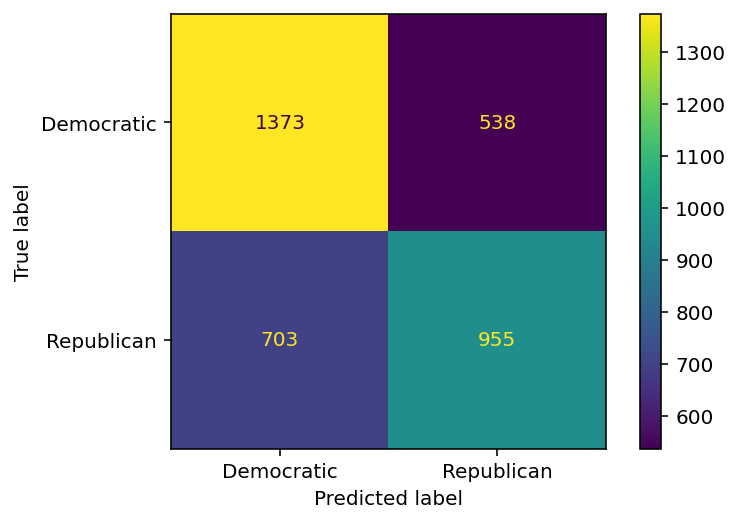

In [291]:
metrics.plot_confusion_matrix(pl_base, X_test, y_test);

In [307]:
acc_demo=1373/(1373+538) # accuracy for Democratic is 0.72
acc_rep= 955/(955+703)  # accuracy for Republican is 0.57

0.5759951749095296

### Final Model

In [217]:
from sklearn.preprocessing import FunctionTransformer

Define a `convert_amount` to convert amount column to a quantative column. We use the lower bound becasue some entry doesn't have upper bound, and it's unreasonable to determine a median. 

In [310]:
def convert_amount(with_party):
    '''
    convert amount to numerical value
    '''
    amount_range=with_party['amount'].str.replace(',','')
    amount_range=amount_range.apply(lambda x:re.findall(r'\$(\d*)',x))
    return amount_range.str[0].to_frame().astype(int)
convert_amount(with_party).head()

,amount
0,1001
1,1001
2,15001
3,15001
4,1001


Define `get_region` function to extract state from `district`, and get its region from `region` dataframe. Because the state of the Representative effects the party affiliation. 

In [329]:
def get_region(with_party):
    stock_region=with_party['district'].str[:2].to_frame()
    merged_region_df=stock_region.merge(region[['State Code','Region']], left_on='district',right_on='State Code')
    return merged_region_df[['Region']]
    
get_region(with_party).head()

,Region
0,South
1,South
2,South
3,South
4,South


Construct ohe_fi to for GridSearch. 

In [340]:
amount_pip = Pipeline([('amount', FunctionTransformer(convert_amount)),\
                       ('ohe',OneHotEncoder(handle_unknown='ignore'))])
region_pip=Pipeline([('region',FunctionTransformer(get_region)), \
                     ('ohe',OneHotEncoder(handle_unknown='ignore'))])
# pass amount, region, type, owner information to ohe_fi
ohe_fi=ColumnTransformer([('amount_pip',amount_pip,['amount']),\
                          ('region_pip',region_pip,['district']),\
                          ('ohe_main',OneHotEncoder(handle_unknown='ignore'),['type','owner'])],remainder='drop')

We use GridSearchCV to find the best max_depth for DecisionTree, and we got 13 as the best paramether.

In [280]:
hyper={'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]}
pl_cv=Pipeline([('ohe',ohe_fi),('searcher',GridSearchCV(DecisionTreeClassifier(),hyper, cv=10))])
pl_cv.fit(X_train, y_train) # fit cv pipeline
pl_cv['searcher'].best_params_

{'max_depth': 13}

We add `amount_lower_bd` and `Region` to the model. `Region` is nominal data, and `amount_lower_bd` is quantitative data. We added `Region` because party affiliation relates to the state of the Representative in. 

In [345]:
amount_pip = Pipeline([('amount', FunctionTransformer(convert_amount)),('ohe',OneHotEncoder(handle_unknown='ignore'))])
region_pip=Pipeline([('region',FunctionTransformer(get_region)), ('ohe',OneHotEncoder(handle_unknown='ignore'))])
preproc=ColumnTransformer([('amount_pip',amount_pip,['amount']),('region_pip',region_pip,['district']),\
                          ('ohe_main',OneHotEncoder(handle_unknown='ignore'),['type','owner'])],remainder='drop')
pl_fi=Pipeline([('preproc',preproc),('dt',DecisionTreeClassifier(max_depth=9))])
pl_fi.fit(X_train,y_train)
pred=pl_fi.predict(X_test)

We got test accuracy to be 0.815, which is improved from baseline model. 

In [331]:
print(pl_fi.score(X_train,y_train)) # train accuracy
pl_fi.score(X_test,y_test) # test accuracy

0.8139013452914798


0.8150742504903334

We ploted confusion matrix, and found that the accuracy for Democratics and Republican both increased. 

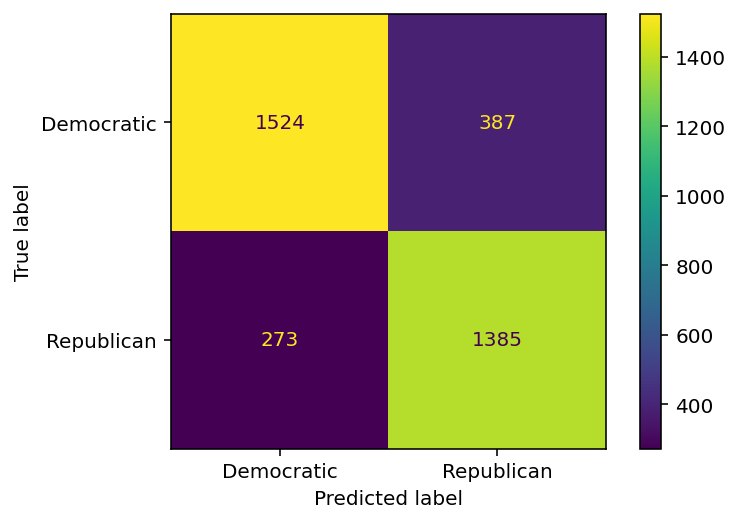

In [298]:
metrics.plot_confusion_matrix(pl_fi, X_test, y_test);

In [309]:
acc_demo=1524/(1524+387) # accuracy for Democratic is 0.79
acc_rep= 1385/(1385+273)  # accuracy for Republican is 0.83

0.8353437876960192


### Fairness Analysis

#### Is the final model fair for purchase type and non-purchase type?

Assign pred_fi to be predicted outcome in final model, and stored it to dataframe `pred_df`.

In [319]:
pred_fi=pl_fi.predict(X)
pred_df=with_party.assign(predict_party=pred_fi)

We are interested in whether the prediction is fair for different type.

In [252]:
pred_df['type'].value_counts()

purchase        7428
sale_full       4562
sale_partial    2155
exchange         128
Name: type, dtype: int64

H0: accuracy for purchase type is fair\
H1: accuracy for purchase type is not fair

Assign `type_purchase` to store whether the type is purchase or not. Groupby `type_purchase` and calculate the observed difference between accuracy, -0.02. We want to know if the observed difference is due to randomness or it's biased.

In [327]:
purchase_df=pred_df.assign(type_purchase=(pred_df['type']=='purchase'))
# calculate accuracy for type_purchase groups
obs=purchase_df.groupby('type_purchase')\
    .apply(lambda x: metrics.accuracy_score(x['Party'], x['predict_party'])) 
print(obs) # observed accuracy for purchase type and non-purchase type
obs_diff=obs.diff().iloc[-1]
print(obs_diff) # observed difference

type_purchase
False    0.825128
True     0.804120
dtype: float64
-0.02100828287572376


Run permutation test to shuffle `type_purchase` column. Calculate the accuracy difference on the shuffled group, and store it in `diff_in_acc`

In [328]:
diff_in_acc = []
for _ in range(100):
    diff = (
        purchase_df
        #shuffle the column
        .assign(type_purchase=purchase_df['type_purchase'].sample(frac=1, replace=False).reset_index(drop=True))
        .groupby('type_purchase')
        .apply(lambda x: metrics.accuracy_score(x['Party'], x['predict_party']))
        .diff().iloc[-1]
    )
    
    diff_in_acc.append(diff)

We plot the shuffed difference distribution and observed difference. We see that observed data is far out of the distribution, which tells us that it's not due to random chance. The model is not fair for purchase type.

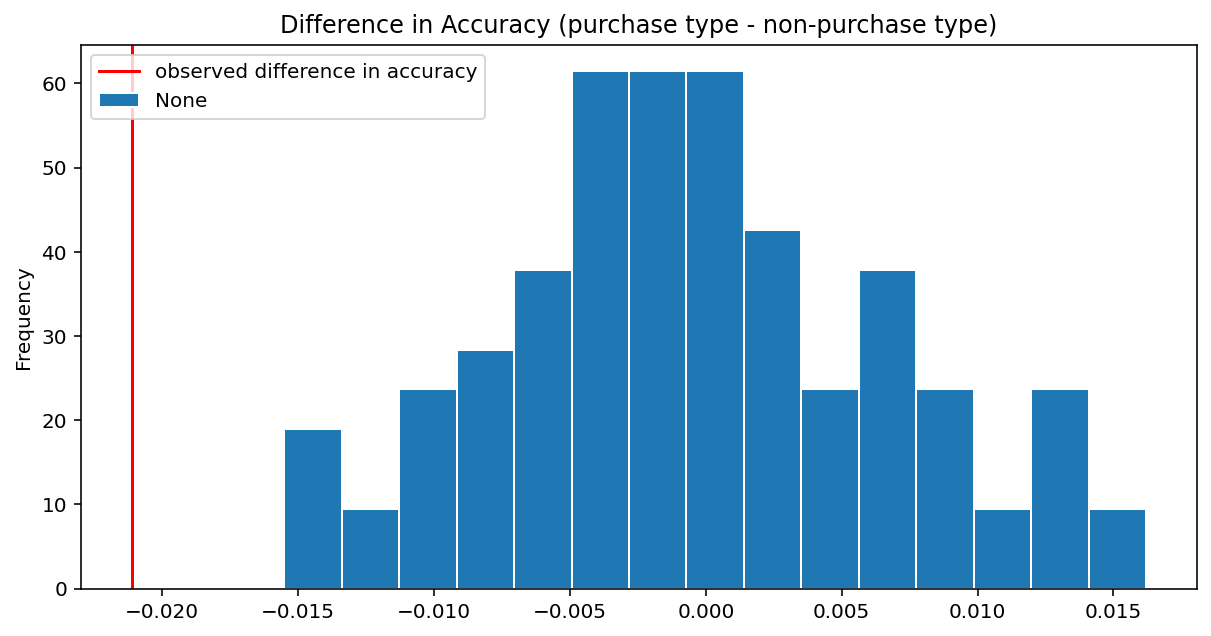

In [275]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_acc).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy (purchase type - non-purchase type)')
plt.axvline(x=obs_diff, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');

In [263]:
# pval
np.mean(np.array(diff_in_acc)<obs_diff)

0.0

Since pval<0.05, we reject H0. We have sufficient evidence to say accuracy for purchase type is not fair. 